In [19]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import numpy as np
from random import shuffle

from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Preparation of datasets

In [4]:
#read data - ChemblID, canonical smiles, standard value and standard unit
data_file = open("./data/beta_amyloidA4_protein_IC50.tsv")
data_file.readline() #read the header (remove it)
def splitter(line):
    spls = line.strip().split("\t")
    if spls[14] != "" and spls[15] != "":
        return (spls[0],Chem.MolFromSmiles(spls[10]),float(spls[14]), spls[15])
mols = [splitter(line) for line in data_file]

In [5]:
len(mols)

854

In [6]:
mols = [m for m in mols if m and m[3] =="nM"]
len(mols)

785

In [7]:
active = [m for m in mols if m[2] < 1000]
active = [a + (1,) for a in active] #add 1 as a clasifier for active
shuffle(active)
len(active), active[:5]

(385,
 [('CHEMBL442801', <rdkit.Chem.rdchem.Mol at 0x1c7398e3ee0>, 3.5, 'nM', 1),
  ('CHEMBL3653726', <rdkit.Chem.rdchem.Mol at 0x1c7398e3ad0>, 1.0, 'nM', 1),
  ('CHEMBL231446', <rdkit.Chem.rdchem.Mol at 0x1c7388e18f0>, 530.0, 'nM', 1),
  ('CHEMBL236190', <rdkit.Chem.rdchem.Mol at 0x1c7388f88a0>, 45.0, 'nM', 1),
  ('CHEMBL200077', <rdkit.Chem.rdchem.Mol at 0x1c7398d2030>, 180.0, 'nM', 1)])

In [8]:
inactive = [m for m in mols if m[2] >= 10000]
inactive = [i + (0,) for i in inactive] #add 0 as a clasifier for non active
len(inactive)

239

In [16]:
splitI = int(len(inactive)*0.7)
splitA = int(len(active)*0.7)

train = active[0:splitA] # + inactive[0:splitI]
test = active[splitA:] # + inactive[splitI:]
len(train), len(test)

(269, 116)

# Random Forest

## Training model

In [17]:
mqns = [rdMolDescriptors.MQNs_(m[1]) for m in train]
vals = [m[2] for m in train]
len(mqns), len(vals)

(269, 269)

### Model 1 - using mqns

In [49]:
# Our old good function to display points
def plot(X, *args, highlights=set()):
    fig = plt.figure()
    #ax = plt.subplot(111)
    for i, point in enumerate(X):
        x,y = point
        if i in highlights:
            plt.plot([x],[y],"r.", markersize=4)
        else:
            plt.plot([x],[y],"k.", markersize=1)
    plt.show()

In [50]:
s = lambda x : -1.0 * np.log10(x / 1.0e9)
pvals = [s(val) for val in vals]

In [52]:
model1 = ensemble.RandomForestRegressor()
model1.fit(mqns, pvals)
preds1 = model1.predict(mqns)

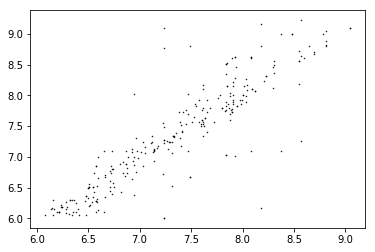

In [53]:
plot(zip(preds1,pvals))

### Model 2 - using Morgan Fingerprints

In [54]:
from rdkit.Chem import AllChem
morgan_fps = [AllChem.GetMorganFingerprintAsBitVect(m[1], 2, nBits=512) for m in train]

In [55]:
model2 = ensemble.RandomForestRegressor()
model2.fit(morgan_fps, pvals)
preds2 = model2.predict(morgan_fps)

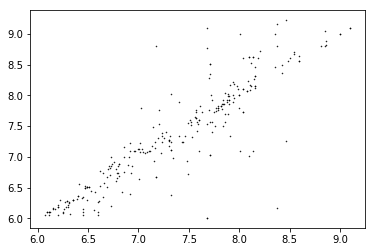

In [56]:
plot(zip(preds2,pvals))

## Testing models on test set

In [62]:
mqns_test = [rdMolDescriptors.MQNs_(m[1]) for m in test]
vals_test = [m[2] for m in test]
morgan_fps_test = [AllChem.GetMorganFingerprintAsBitVect(m[1], 2, nBits=512) for m in test]
pvals_test = [s(val) for val in vals_test]

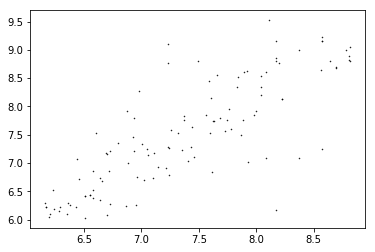

In [57]:
test_predictions1 = model1.predict(mqns_test)
plot(zip(test_predictions1, pvals_test))

In [59]:
print("R^2: %0.2f" % model1.score(mqns_test, pvals_test))
print("R: %0.2f" % np.sqrt(model1.score(mqns_test, pvals_test)))
print("MSE: %0.2f" %  mean_squared_error(model1.predict(mqns_test), pvals_test))

R^2: 0.64
R: 0.80
MSE: 0.33


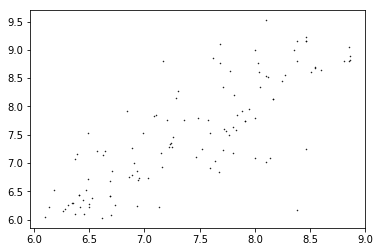

In [63]:
test_predictions2 = model2.predict(morgan_fps_test)
plot(zip(test_predictions2, pvals_test))

In [64]:
print("R^2: %0.2f" % model2.score(morgan_fps_test, pvals_test))
print("R: %0.2f" % np.sqrt(model2.score(morgan_fps_test, pvals_test)))
print("MSE: %0.2f" %  mean_squared_error(model2.predict(morgan_fps_test), pvals_test))

R^2: 0.63
R: 0.79
MSE: 0.34


# SVM Regression


In [68]:
clf = svm.SVR()
clf.fit(mqns, pvals)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

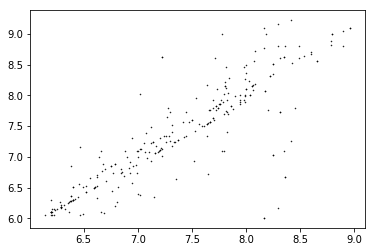

In [70]:
svm_preds1 = clf.predict(mqns)
plot(zip(svm_preds1,pvals))